In [1]:
# import the necessary packages
import argparse
import cv2
import matplotlib.pyplot as plt
from os import walk
import os
import glob
import matplotlib
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [2]:
print(cv2.__version__)

4.9.0


In [3]:
pore_data = pd.DataFrame(columns=["img", "label", "x1", "y1", "x2", "y2"])
disposal_pore = pd.DataFrame(columns=["img", "label", "x1", "y1", "x2", "y2"])
pore_data

,img,label,x1,y1,x2,y2


In [4]:
def load_all_image_path(img_dir):
    #img_dir = "./Build2" # Enter Directory of all images
    img_labels = []
    for(_, _, filenames) in walk(img_dir):
        img_labels.extend(filenames)
        break
    data_path = os.path.join(img_dir,'*g')
    files = glob.glob(data_path)
    return files, img_labels

In [5]:
def isKeepable(x, y, pore_data):
    for _, p in pore_data.iterrows():
        distance = ((x - p.x1)**2 + (y - p.y1)**2)**(1/2)
        
        if distance < 5:
            pore_data
            return [False, p, distance]
            
    return [True]

In [6]:
def CCA_pore(img):
    pore_data = pd.DataFrame(columns=["img", "label", "x1", "y1", "x2", "y2"])
    
    ## load the input image from disk 
    image = cv2.imread(img)
    #image = cv2.imread("license_plat.png")

    ## convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    ## threshold image
    thresh = cv2.threshold(gray, 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

    ## apply connected component analysis to the thresholded image
    output = cv2.connectedComponentsWithStats(thresh,8, cv2.CV_32S)
    (numLabels, labels, stats, centroids) = output
    
    #### total detected instances
    #print("Total number of objects: ", numLabels)

    pore_output = image.copy()
    b_box = 0

    # loop over the number of unique connected component labels
    for i in range(0, numLabels):
        # extract the connected component statistics and centroid for the current label
        x = stats[i, cv2.CC_STAT_LEFT]
        y = stats[i, cv2.CC_STAT_TOP]
        w = stats[i, cv2.CC_STAT_WIDTH]
        h = stats[i, cv2.CC_STAT_HEIGHT]
        area = stats[i, cv2.CC_STAT_AREA]
        (cX, cY) = centroids[i]

        ## If the pore area is bigger then 5 only than draw a bounding box
        if (area > 5 and area < 200):
            pore_data.loc[pore_data.shape[0]] = [img[-15:], 0, x, y, x + w, y + h]
            
            ## bounding box counter
            b_box+=1
                
            ## Draw bounding box and a circle for the center of bounding box around the pore
            pore_output = cv2.rectangle(pore_output, (x-20, y-20), (x + w+20, y + h+20), (0, 255, 0), 1)
            pore_output = cv2.circle(pore_output, (int(cX), int(cY)), 4, (0, 0, 255), 1)
            
    #print(b_box)
    #plt.imshow(pore_output)
    return pore_output, b_box, pore_data

def CCA_pore_with_disposal(img):
    pore_data = pd.DataFrame(columns=["img", "label", "x1", "y1", "x2", "y2"])
    disposal_pore = pd.DataFrame(columns=["img", "label", "x1", "y1", "x2", "y2", "pore close with", "distance"])

    ## load the input image from disk 
    image = cv2.imread(img)
    #image = cv2.imread("license_plat.png")

    ## convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    ## threshold image
    thresh = cv2.threshold(gray, 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

    ## apply connected component analysis to the thresholded image
    output = cv2.connectedComponentsWithStats(thresh,8, cv2.CV_32S)
    (numLabels, labels, stats, centroids) = output
    
    #### total detected instances
    #print("Total number of objects: ", numLabels)

    pore_output = image.copy()
    b_box = 0

    # loop over the number of unique connected component labels
    for i in range(0, numLabels):
        # extract the connected component statistics and centroid for the current label
        x = stats[i, cv2.CC_STAT_LEFT]
        y = stats[i, cv2.CC_STAT_TOP]
        w = stats[i, cv2.CC_STAT_WIDTH]
        h = stats[i, cv2.CC_STAT_HEIGHT]
        area = stats[i, cv2.CC_STAT_AREA]
        (cX, cY) = centroids[i]

        ## If the pore area is bigger then 5 only than draw a bounding box
        if (area > 5 and area < 200):
            keep = isKeepable(x, y, pore_data[pore_data['img'] == img[-15:]])
            if keep[0]:
                pore_data.loc[pore_data.shape[0]] = [img[-15:], 0, x, y, x + w, y + h]
            else:
                disposal_pore.loc[disposal_pore.shape[0]] = [img[-15:], 1, x, y, x + w, y + h, keep[1].name, keep[2]]
                continue

            ## bounding box counter
            b_box+=1
                
            ## Draw bounding box and a circle for the center of bounding box around the pore
            pore_output = cv2.rectangle(pore_output, (x-20, y-20), (x + w+20, y + h+20), (0, 255, 0), 1)
            pore_output = cv2.circle(pore_output, (int(cX), int(cY)), 4, (0, 0, 255), 1)
            
    #print(b_box)
    #plt.imshow(pore_output)
    return pore_output, b_box, pore_data, disposal_pore

## Make directories to store labelled images

In [7]:
# Make directories to store crop images if the the directories don't exsists already
random_directories = ["Corrections/4 - Object detection/Labeled_CCA/Test/", 
                      "Corrections/4 - Object detection/Labeled_CCA/Train/",
                      "Corrections/4 - Object detection/Labeled_CCA/Valid/",
                      "Corrections/4 - Object detection/Labeled_CCA(without_pore_disposal)/Test/", 
                      "Corrections/4 - Object detection/Labeled_CCA(without_pore_disposal)/Train/",
                      "Corrections/4 - Object detection/Labeled_CCA(without_pore_disposal)/Valid/"]

for directory in random_directories:
    if not os.path.exists(directory):
        os.makedirs(directory)
       
### delete old files in the directories
for directory in random_directories:
    files = glob.glob(os.path.join(directory,"*"))
    for f in files:
        os.remove(f)

### Testing Images

## Without Pore Disposal

In [8]:
img_dir_paths, img_names = load_all_image_path("Corrections/4 - Object detection/porosity_data/images/test/")
pore_data_without_pore_disposal = pd.DataFrame(columns=["img", "label", "x1", "y1", "x2", "y2"])

without_pore_disposal = dict()
for img, img_Name in zip(img_dir_paths, img_names):
    label_img, label_count, p_data = CCA_pore(img)
    print(str(img_Name) + ": " + str(label_count))
    print(label_count)
    
    pore_data_without_pore_disposal = pd.concat([pore_data_without_pore_disposal, p_data])
    without_pore_disposal[img_Name] = [label_img, label_count]
    
    ## save image
    img_name = "Corrections/4 - Object detection/Labeled_CCA(without_pore_disposal)/Test/" + img_Name
    matplotlib.image.imsave(img_name, label_img)

pore_data_without_pore_disposal.set_index(["img"], inplace=True)

A20X_7_0266.jpg: 50
50
A20X_7_0267.jpg: 50
50
A20X_7_0268.jpg: 47
47
A20X_7_0269.jpg: 45
45
A20X_7_0270.jpg: 47
47
A20X_7_1160.jpg: 199
199
A20X_7_1161.jpg: 188
188


## With Pore Disposal

In [9]:
img_dir_paths, img_names = load_all_image_path("Corrections/4 - Object detection/porosity_data/images/test/")
pore_data_with_pore_disposal = pd.DataFrame(columns=["img", "label", "x1", "y1", "x2", "y2"])
disposal_pore = pd.DataFrame(columns=["img", "label", "x1", "y1", "x2", "y2", "pore close with", "distance"])

with_pore_disposal = dict()
for img, img_Name in zip(img_dir_paths, img_names):
    label_img, label_count, p_data, disposal_p_date = CCA_pore_with_disposal(img)
    print(str(img_Name) + ": " + str(label_count))
    print(label_count)
    
    pore_data_with_pore_disposal = pd.concat([pore_data_with_pore_disposal, p_data])
    disposal_pore = pd.concat([disposal_pore, disposal_p_date])
    
    with_pore_disposal[img_Name] = [label_img, label_count]
    
    ## save image
    img_name = "Corrections/4 - Object detection/Labeled_CCA/Test/" + img_Name
    matplotlib.image.imsave(img_name, label_img)

pore_data_with_pore_disposal.set_index(["img"], inplace=True)

A20X_7_0266.jpg: 49
49
A20X_7_0267.jpg: 49
49
A20X_7_0268.jpg: 45
45
A20X_7_0269.jpg: 45
45
A20X_7_0270.jpg: 47
47
A20X_7_1160.jpg: 196
196
A20X_7_1161.jpg: 185
185


A20X_7_1161.jpg
Without Pore Disposal : 188
188
With Pore Disposal: 185
185


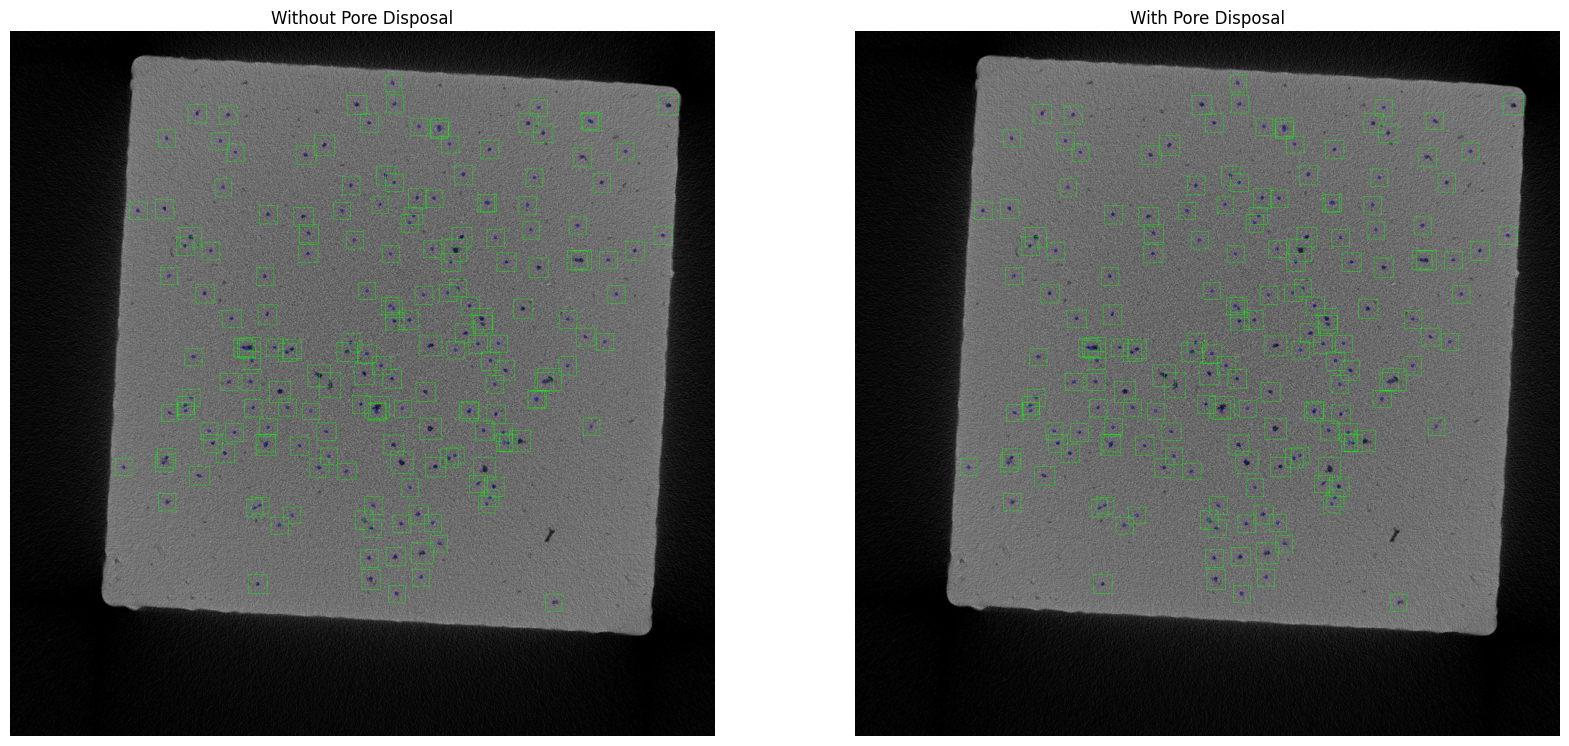

In [10]:
img_Name = "A20X_7_1161.jpg"
print(img_Name)

plt.figure(figsize=(20,10))

print("Without Pore Disposal : " + str(without_pore_disposal[img_Name][1]))
print(without_pore_disposal[img_Name][1])
plt.subplot(1, 2, 1)
plt.title('Without Pore Disposal')
plt.axis("off");
plt.imshow(without_pore_disposal[img_Name][0])


print("With Pore Disposal: " + str(with_pore_disposal[img_Name][1]))
print(with_pore_disposal[img_Name][1])
plt.subplot(1, 2, 2)
plt.title('With Pore Disposal')
plt.axis("off");
plt.imshow(with_pore_disposal[img_Name][0])

In [13]:
for img in pore_data_with_pore_disposal.index.unique():
    pore_data_with_pore_disposal.loc[img].to_csv(img[:-4] + '.txt', index=False, header=None)

### Training Images

In [ ]:
img_dir_paths, img_names = load_all_image_path("Corrections/4 - Object detection/porosity_data/images/train/")
# print(img_dir_paths[0])
# print(img_names[0])

for img, img_Name in zip(img_dir_paths, img_names):
    label_img, label_count = CCA_pore(img)
    print(str(img_Name) + ": " + str(label_count))
    #plt.imshow(label_img)
    #plt.show()
    
    ## save image
    img_name = "Corrections/4 - Object detection/Labeled_CCA/Train/" + img_Name
    matplotlib.image.imsave(img_name, label_img)

Width: 9 Height: 6 Area: 29
Width: 6 Height: 5 Area: 16
Width: 5 Height: 5 Area: 14
Width: 5 Height: 8 Area: 26
Width: 6 Height: 5 Area: 14
Width: 3 Height: 4 Area: 8
Width: 7 Height: 5 Area: 19
Width: 5 Height: 6 Area: 13
Width: 8 Height: 8 Area: 40
Width: 3 Height: 5 Area: 7
Width: 6 Height: 10 Area: 29
Width: 4 Height: 4 Area: 7
Width: 5 Height: 4 Area: 7
Width: 17 Height: 10 Area: 71
Width: 5 Height: 5 Area: 13
Width: 8 Height: 7 Area: 34
Width: 14 Height: 13 Area: 70
Width: 5 Height: 4 Area: 10
Width: 4 Height: 3 Area: 7
Width: 15 Height: 22 Area: 143
Width: 4 Height: 4 Area: 10
Width: 4 Height: 4 Area: 9
Width: 15 Height: 22 Area: 168
Width: 4 Height: 2 Area: 7
Width: 2 Height: 4 Area: 6
Width: 10 Height: 9 Area: 43
Width: 4 Height: 5 Area: 10
Width: 9 Height: 5 Area: 14
Width: 7 Height: 10 Area: 23
Width: 5 Height: 6 Area: 10
Width: 15 Height: 12 Area: 78
Width: 3 Height: 4 Area: 7
Width: 4 Height: 3 Area: 7
Width: 4 Height: 4 Area: 9
Width: 18 Height: 15 Area: 143
Width: 5 Heig

Width: 9 Height: 10 Area: 33
Width: 3 Height: 4 Area: 7
Width: 9 Height: 10 Area: 44
Width: 5 Height: 4 Area: 11
Width: 3 Height: 3 Area: 6
Width: 12 Height: 12 Area: 68
Width: 5 Height: 7 Area: 18
Width: 12 Height: 9 Area: 57
Width: 10 Height: 8 Area: 45
Width: 8 Height: 6 Area: 18
Width: 14 Height: 8 Area: 47
Width: 16 Height: 11 Area: 60
Width: 3 Height: 3 Area: 7
Width: 2 Height: 5 Area: 6
Width: 6 Height: 9 Area: 23
Width: 13 Height: 13 Area: 94
Width: 9 Height: 11 Area: 66
Width: 7 Height: 6 Area: 25
Width: 6 Height: 8 Area: 29
Width: 3 Height: 4 Area: 9
Width: 3 Height: 3 Area: 7
Width: 3 Height: 3 Area: 6
Width: 5 Height: 3 Area: 8
Width: 4 Height: 7 Area: 11
Width: 4 Height: 5 Area: 11
Width: 15 Height: 13 Area: 65
Width: 15 Height: 17 Area: 127
Width: 4 Height: 4 Area: 8
Width: 13 Height: 20 Area: 111
Width: 5 Height: 5 Area: 14
Width: 4 Height: 4 Area: 9
Width: 6 Height: 7 Area: 18
Width: 5 Height: 5 Area: 12
Width: 4 Height: 3 Area: 6
Width: 3 Height: 5 Area: 9
Width: 9 Hei

Width: 10 Height: 9 Area: 50
Width: 7 Height: 9 Area: 46
Width: 5 Height: 9 Area: 16
Width: 5 Height: 8 Area: 23
Width: 5 Height: 6 Area: 16
Width: 12 Height: 6 Area: 44
Width: 13 Height: 7 Area: 44
Width: 7 Height: 3 Area: 14
Width: 6 Height: 2 Area: 7
Width: 18 Height: 14 Area: 124
Width: 5 Height: 4 Area: 12
Width: 3 Height: 5 Area: 8
Width: 5 Height: 3 Area: 10
Width: 3 Height: 3 Area: 6
Width: 4 Height: 6 Area: 16
Width: 14 Height: 16 Area: 100
Width: 5 Height: 5 Area: 15
Width: 9 Height: 9 Area: 45
Width: 10 Height: 8 Area: 40
Width: 7 Height: 10 Area: 33
Width: 6 Height: 3 Area: 13
Width: 4 Height: 3 Area: 7
Width: 10 Height: 10 Area: 53
Width: 9 Height: 4 Area: 18
Width: 17 Height: 18 Area: 101
Width: 4 Height: 4 Area: 6
Width: 3 Height: 6 Area: 10
Width: 6 Height: 12 Area: 24
Width: 7 Height: 4 Area: 18
Width: 7 Height: 3 Area: 13
Width: 6 Height: 5 Area: 15
Width: 3 Height: 3 Area: 8
Width: 13 Height: 11 Area: 64
Width: 30 Height: 18 Area: 166
Width: 5 Height: 7 Area: 16
Widt

Width: 9 Height: 5 Area: 29
Width: 4 Height: 3 Area: 7
Width: 4 Height: 9 Area: 22
Width: 5 Height: 3 Area: 8
Width: 3 Height: 5 Area: 7
Width: 4 Height: 5 Area: 9
Width: 5 Height: 5 Area: 16
Width: 18 Height: 14 Area: 93
Width: 17 Height: 16 Area: 137
Width: 4 Height: 3 Area: 7
Width: 4 Height: 5 Area: 9
Width: 9 Height: 5 Area: 26
Width: 10 Height: 13 Area: 44
Width: 6 Height: 4 Area: 10
Width: 8 Height: 8 Area: 32
Width: 10 Height: 10 Area: 31
Width: 8 Height: 9 Area: 28
Width: 2 Height: 6 Area: 6
Width: 5 Height: 5 Area: 12
Width: 5 Height: 5 Area: 12
Width: 7 Height: 6 Area: 21
Width: 6 Height: 8 Area: 24
Width: 12 Height: 9 Area: 52
Width: 4 Height: 4 Area: 12
Width: 6 Height: 6 Area: 21
Width: 6 Height: 3 Area: 7
Width: 7 Height: 6 Area: 22
Width: 4 Height: 4 Area: 12
Width: 4 Height: 3 Area: 8
Width: 5 Height: 3 Area: 9
Width: 5 Height: 3 Area: 9
Width: 6 Height: 6 Area: 10
Width: 4 Height: 3 Area: 7
Width: 6 Height: 5 Area: 13
Width: 6 Height: 5 Area: 19
Width: 4 Height: 3 Are

Width: 8 Height: 5 Area: 19
Width: 3 Height: 7 Area: 11
Width: 3 Height: 3 Area: 6
Width: 2 Height: 3 Area: 6
Width: 16 Height: 11 Area: 69
Width: 9 Height: 8 Area: 42
Width: 3 Height: 5 Area: 8
Width: 5 Height: 6 Area: 21
Width: 9 Height: 5 Area: 31
Width: 4 Height: 4 Area: 8
Width: 3 Height: 4 Area: 7
Width: 3 Height: 5 Area: 11
Width: 7 Height: 6 Area: 19
Width: 7 Height: 7 Area: 19
Width: 4 Height: 5 Area: 8
Width: 5 Height: 4 Area: 10
Width: 14 Height: 14 Area: 102
Width: 9 Height: 8 Area: 39
Width: 3 Height: 6 Area: 9
Width: 4 Height: 4 Area: 9
Width: 6 Height: 5 Area: 15
Width: 7 Height: 9 Area: 37
Width: 4 Height: 6 Area: 11
Width: 4 Height: 2 Area: 6
Width: 3 Height: 3 Area: 6
Width: 9 Height: 11 Area: 34
Width: 6 Height: 4 Area: 8
Width: 7 Height: 8 Area: 26
Width: 6 Height: 6 Area: 17
Width: 8 Height: 10 Area: 34
Width: 5 Height: 4 Area: 13
Width: 6 Height: 4 Area: 10
Width: 7 Height: 4 Area: 13
Width: 3 Height: 4 Area: 6
Width: 11 Height: 7 Area: 23
Width: 6 Height: 4 Area:

Width: 4 Height: 3 Area: 7
Width: 3 Height: 3 Area: 8
Width: 2 Height: 7 Area: 9
Width: 4 Height: 4 Area: 9
Width: 8 Height: 6 Area: 27
Width: 11 Height: 14 Area: 103
Width: 4 Height: 5 Area: 11
Width: 7 Height: 7 Area: 22
Width: 5 Height: 5 Area: 18
Width: 6 Height: 6 Area: 12
Width: 8 Height: 9 Area: 31
Width: 9 Height: 7 Area: 36
Width: 6 Height: 3 Area: 12
Width: 4 Height: 3 Area: 6
Width: 7 Height: 6 Area: 22
Width: 12 Height: 13 Area: 79
Width: 10 Height: 18 Area: 82
Width: 8 Height: 7 Area: 30
Width: 11 Height: 10 Area: 47
Width: 11 Height: 7 Area: 51
Width: 8 Height: 9 Area: 38
Width: 5 Height: 2 Area: 6
Width: 8 Height: 6 Area: 18
Width: 8 Height: 5 Area: 22
Width: 5 Height: 3 Area: 10
Width: 6 Height: 10 Area: 33
Width: 9 Height: 9 Area: 44
Width: 5 Height: 7 Area: 17
Width: 4 Height: 5 Area: 14
Width: 4 Height: 3 Area: 6
Width: 3 Height: 3 Area: 6
Width: 5 Height: 5 Area: 9
Width: 3 Height: 4 Area: 7
Width: 7 Height: 4 Area: 16
Width: 5 Height: 7 Area: 19
Width: 16 Height: 1

Width: 3 Height: 2 Area: 6
Width: 7 Height: 6 Area: 18
Width: 3 Height: 3 Area: 6
Width: 7 Height: 6 Area: 23
Width: 6 Height: 6 Area: 24
Width: 11 Height: 11 Area: 71
Width: 5 Height: 4 Area: 10
Width: 5 Height: 3 Area: 11
Width: 3 Height: 4 Area: 8
Width: 8 Height: 8 Area: 21
Width: 5 Height: 3 Area: 9
Width: 4 Height: 4 Area: 8
Width: 17 Height: 18 Area: 125
Width: 3 Height: 5 Area: 10
Width: 9 Height: 7 Area: 25
Width: 8 Height: 8 Area: 23
Width: 8 Height: 8 Area: 39
Width: 12 Height: 9 Area: 45
Width: 9 Height: 5 Area: 15
Width: 4 Height: 5 Area: 8
Width: 9 Height: 14 Area: 58
Width: 5 Height: 6 Area: 21
Width: 11 Height: 7 Area: 42
Width: 8 Height: 7 Area: 36
Width: 13 Height: 15 Area: 75
Width: 7 Height: 5 Area: 14
Width: 2 Height: 5 Area: 7
Width: 5 Height: 3 Area: 6
Width: 5 Height: 6 Area: 10
Width: 4 Height: 7 Area: 13
Width: 6 Height: 6 Area: 14
Width: 8 Height: 8 Area: 40
Width: 3 Height: 6 Area: 11
Width: 5 Height: 4 Area: 11
Width: 4 Height: 4 Area: 9
Width: 7 Height: 7 

Width: 2 Height: 4 Area: 6
Width: 5 Height: 4 Area: 11
Width: 3 Height: 4 Area: 7
Width: 2 Height: 4 Area: 7
Width: 7 Height: 9 Area: 31
Width: 7 Height: 9 Area: 40
Width: 4 Height: 5 Area: 13
Width: 7 Height: 6 Area: 21
Width: 6 Height: 6 Area: 13
Width: 13 Height: 13 Area: 59
Width: 4 Height: 4 Area: 11
Width: 9 Height: 11 Area: 42
Width: 4 Height: 7 Area: 21
Width: 5 Height: 4 Area: 11
Width: 5 Height: 7 Area: 18
Width: 4 Height: 8 Area: 20
Width: 6 Height: 5 Area: 18
Width: 2 Height: 5 Area: 8
Width: 12 Height: 9 Area: 67
Width: 12 Height: 10 Area: 65
Width: 8 Height: 8 Area: 33
Width: 9 Height: 5 Area: 28
Width: 5 Height: 5 Area: 16
Width: 11 Height: 6 Area: 39
Width: 4 Height: 3 Area: 7
Width: 4 Height: 5 Area: 9
Width: 10 Height: 11 Area: 57
Width: 18 Height: 19 Area: 130
Width: 13 Height: 16 Area: 87
Width: 3 Height: 4 Area: 9
Width: 4 Height: 5 Area: 13
Width: 8 Height: 8 Area: 34
Width: 2 Height: 4 Area: 6
Width: 8 Height: 6 Area: 21
Width: 6 Height: 5 Area: 14
Width: 6 Heigh

Width: 3 Height: 3 Area: 6
Width: 10 Height: 6 Area: 35
Width: 7 Height: 3 Area: 9
Width: 6 Height: 8 Area: 32
Width: 9 Height: 10 Area: 46
Width: 15 Height: 14 Area: 108
Width: 11 Height: 15 Area: 77
Width: 4 Height: 3 Area: 6
Width: 6 Height: 7 Area: 25
Width: 7 Height: 7 Area: 23
Width: 6 Height: 10 Area: 29
Width: 5 Height: 8 Area: 29
Width: 10 Height: 8 Area: 40
Width: 6 Height: 7 Area: 18
Width: 12 Height: 9 Area: 55
Width: 3 Height: 3 Area: 7
Width: 4 Height: 4 Area: 9
Width: 14 Height: 10 Area: 76
Width: 11 Height: 8 Area: 61
Width: 3 Height: 4 Area: 6
Width: 8 Height: 7 Area: 29
Width: 3 Height: 4 Area: 6
Width: 4 Height: 3 Area: 6
Width: 4 Height: 6 Area: 15
Width: 6 Height: 6 Area: 16
Width: 6 Height: 8 Area: 21
Width: 3 Height: 5 Area: 10
Width: 10 Height: 5 Area: 24
Width: 4 Height: 3 Area: 9
Width: 4 Height: 4 Area: 8
Width: 10 Height: 12 Area: 74
Width: 14 Height: 18 Area: 113
Width: 14 Height: 19 Area: 143
Width: 6 Height: 3 Area: 12
Width: 7 Height: 5 Area: 20
Width: 5

Width: 4 Height: 4 Area: 9
Width: 15 Height: 12 Area: 77
Width: 11 Height: 7 Area: 51
Width: 5 Height: 5 Area: 11
Width: 10 Height: 12 Area: 61
Width: 3 Height: 4 Area: 7
Width: 3 Height: 4 Area: 9
Width: 7 Height: 7 Area: 25
Width: 3 Height: 4 Area: 10
Width: 7 Height: 6 Area: 18
Width: 13 Height: 12 Area: 99
Width: 15 Height: 18 Area: 137
Width: 7 Height: 6 Area: 19
Width: 15 Height: 10 Area: 83
Width: 6 Height: 6 Area: 16
Width: 6 Height: 5 Area: 17
Width: 6 Height: 4 Area: 11
Width: 3 Height: 5 Area: 10
Width: 8 Height: 9 Area: 40
Width: 8 Height: 7 Area: 33
Width: 5 Height: 4 Area: 8
Width: 6 Height: 3 Area: 11
Width: 3 Height: 3 Area: 7
Width: 7 Height: 5 Area: 18
Width: 15 Height: 10 Area: 47
Width: 6 Height: 3 Area: 11
Width: 6 Height: 8 Area: 26
Width: 11 Height: 8 Area: 48
Width: 6 Height: 5 Area: 17
Width: 18 Height: 25 Area: 150
Width: 7 Height: 5 Area: 15
Width: 7 Height: 7 Area: 20
Width: 13 Height: 12 Area: 95
Width: 12 Height: 12 Area: 66
Width: 19 Height: 17 Area: 164


Width: 3 Height: 4 Area: 7
Width: 4 Height: 6 Area: 14
Width: 8 Height: 8 Area: 38
Width: 4 Height: 3 Area: 8
Width: 5 Height: 6 Area: 13
Width: 4 Height: 6 Area: 10
Width: 4 Height: 6 Area: 19
Width: 5 Height: 6 Area: 17
Width: 14 Height: 8 Area: 53
Width: 15 Height: 17 Area: 124
Width: 3 Height: 4 Area: 6
Width: 11 Height: 18 Area: 124
Width: 4 Height: 4 Area: 12
Width: 7 Height: 7 Area: 30
Width: 18 Height: 15 Area: 63
Width: 5 Height: 5 Area: 17
Width: 8 Height: 6 Area: 27
Width: 4 Height: 5 Area: 11
Width: 3 Height: 3 Area: 7
Width: 5 Height: 5 Area: 8
Width: 11 Height: 17 Area: 104
Width: 11 Height: 10 Area: 49
Width: 12 Height: 13 Area: 63
Width: 3 Height: 5 Area: 6
Width: 5 Height: 4 Area: 10
Width: 13 Height: 12 Area: 66
Width: 5 Height: 6 Area: 8
Width: 5 Height: 3 Area: 9
Width: 5 Height: 5 Area: 15
Width: 9 Height: 7 Area: 39
Width: 9 Height: 8 Area: 33
Width: 7 Height: 4 Area: 14
Width: 3 Height: 8 Area: 11
Width: 10 Height: 8 Area: 27
Width: 7 Height: 6 Area: 20
Width: 3 

Width: 5 Height: 4 Area: 14
Width: 6 Height: 8 Area: 26
Width: 9 Height: 8 Area: 37
Width: 10 Height: 10 Area: 58
Width: 8 Height: 7 Area: 20
Width: 10 Height: 8 Area: 46
Width: 16 Height: 16 Area: 100
Width: 3 Height: 3 Area: 7
Width: 6 Height: 6 Area: 21
Width: 15 Height: 17 Area: 114
Width: 8 Height: 9 Area: 38
Width: 9 Height: 8 Area: 26
Width: 3 Height: 3 Area: 6
Width: 12 Height: 18 Area: 128
Width: 7 Height: 6 Area: 18
Width: 9 Height: 9 Area: 41
Width: 12 Height: 13 Area: 93
Width: 8 Height: 7 Area: 24
Width: 5 Height: 5 Area: 16
Width: 9 Height: 7 Area: 30
Width: 5 Height: 9 Area: 20
Width: 7 Height: 8 Area: 22
Width: 15 Height: 21 Area: 142
Width: 10 Height: 6 Area: 31
Width: 4 Height: 2 Area: 7
Width: 8 Height: 8 Area: 25
Width: 3 Height: 3 Area: 7
Width: 5 Height: 6 Area: 13
Width: 13 Height: 10 Area: 80
Width: 6 Height: 8 Area: 22
Width: 3 Height: 7 Area: 16
Width: 13 Height: 11 Area: 75
Width: 4 Height: 4 Area: 8
Width: 6 Height: 3 Area: 10
Width: 14 Height: 6 Area: 31
Wi

Width: 4 Height: 4 Area: 12
Width: 4 Height: 6 Area: 9
Width: 8 Height: 7 Area: 29
Width: 3 Height: 3 Area: 7
Width: 10 Height: 11 Area: 81
Width: 4 Height: 4 Area: 8
Width: 7 Height: 7 Area: 26
Width: 13 Height: 14 Area: 63
Width: 12 Height: 17 Area: 126
Width: 4 Height: 5 Area: 10
Width: 10 Height: 12 Area: 47
Width: 4 Height: 6 Area: 10
Width: 5 Height: 5 Area: 12
Width: 2 Height: 4 Area: 6
Width: 11 Height: 11 Area: 42
Width: 10 Height: 13 Area: 82
Width: 7 Height: 8 Area: 31
Width: 14 Height: 18 Area: 125
Width: 7 Height: 6 Area: 29
Width: 7 Height: 7 Area: 25
Width: 9 Height: 13 Area: 34
Width: 13 Height: 9 Area: 50
Width: 10 Height: 10 Area: 43
Width: 13 Height: 17 Area: 121
Width: 10 Height: 6 Area: 24
Width: 6 Height: 3 Area: 13
Width: 6 Height: 9 Area: 36
Width: 10 Height: 11 Area: 71
Width: 6 Height: 6 Area: 12
Width: 4 Height: 5 Area: 11
Width: 5 Height: 3 Area: 10
Width: 16 Height: 15 Area: 103
Width: 2 Height: 4 Area: 6
Width: 4 Height: 5 Area: 9
Width: 5 Height: 4 Area: 

Width: 12 Height: 10 Area: 82
Width: 4 Height: 3 Area: 7
Width: 15 Height: 20 Area: 144
Width: 5 Height: 9 Area: 28
Width: 5 Height: 7 Area: 20
Width: 5 Height: 7 Area: 22
Width: 5 Height: 4 Area: 13
Width: 6 Height: 5 Area: 11
Width: 3 Height: 4 Area: 8
Width: 11 Height: 13 Area: 79
Width: 7 Height: 9 Area: 32
Width: 6 Height: 4 Area: 14
Width: 9 Height: 8 Area: 42
Width: 3 Height: 4 Area: 6
Width: 9 Height: 7 Area: 36
Width: 4 Height: 3 Area: 7
Width: 4 Height: 5 Area: 10
Width: 12 Height: 6 Area: 31
Width: 5 Height: 5 Area: 14
Width: 13 Height: 10 Area: 51
Width: 3 Height: 2 Area: 6
Width: 6 Height: 8 Area: 24
Width: 4 Height: 5 Area: 11
Width: 4 Height: 6 Area: 15
Width: 4 Height: 3 Area: 7
Width: 9 Height: 12 Area: 46
Width: 5 Height: 4 Area: 9
Width: 7 Height: 8 Area: 27
Width: 5 Height: 2 Area: 7
Width: 9 Height: 8 Area: 27
Width: 6 Height: 6 Area: 15
Width: 6 Height: 5 Area: 12
Width: 10 Height: 14 Area: 45
Width: 11 Height: 7 Area: 34
Width: 10 Height: 20 Area: 63
Width: 4 Hei

Width: 8 Height: 10 Area: 36
Width: 6 Height: 9 Area: 33
Width: 4 Height: 3 Area: 8
Width: 11 Height: 7 Area: 35
Width: 4 Height: 4 Area: 10
Width: 4 Height: 3 Area: 10
Width: 14 Height: 19 Area: 170
Width: 4 Height: 5 Area: 12
Width: 4 Height: 12 Area: 25
Width: 7 Height: 11 Area: 34
Width: 5 Height: 10 Area: 20
Width: 6 Height: 6 Area: 13
Width: 3 Height: 3 Area: 6
Width: 4 Height: 2 Area: 7
Width: 10 Height: 14 Area: 80
Width: 6 Height: 7 Area: 22
Width: 6 Height: 4 Area: 15
Width: 14 Height: 8 Area: 58
Width: 10 Height: 8 Area: 33
Width: 3 Height: 5 Area: 6
Width: 2 Height: 3 Area: 6
Width: 4 Height: 3 Area: 7
Width: 4 Height: 7 Area: 13
Width: 5 Height: 3 Area: 7
Width: 3 Height: 3 Area: 7
Width: 9 Height: 6 Area: 19
Width: 4 Height: 4 Area: 8
Width: 7 Height: 4 Area: 14
Width: 4 Height: 7 Area: 14
Width: 5 Height: 2 Area: 6
Width: 5 Height: 3 Area: 7
Width: 3 Height: 4 Area: 6
Width: 3 Height: 4 Area: 10
Width: 3 Height: 4 Area: 7
Width: 5 Height: 4 Area: 11
Width: 8 Height: 6 Ar

Width: 5 Height: 6 Area: 16
Width: 6 Height: 6 Area: 19
Width: 4 Height: 2 Area: 6
Width: 14 Height: 18 Area: 118
Width: 12 Height: 8 Area: 32
Width: 4 Height: 4 Area: 9
Width: 5 Height: 5 Area: 12
Width: 5 Height: 8 Area: 19
Width: 7 Height: 13 Area: 45
Width: 4 Height: 5 Area: 9
Width: 8 Height: 6 Area: 23
Width: 2 Height: 4 Area: 7
Width: 4 Height: 5 Area: 13
Width: 7 Height: 13 Area: 47
Width: 8 Height: 9 Area: 25
Width: 5 Height: 4 Area: 14
Width: 15 Height: 9 Area: 69
Width: 5 Height: 6 Area: 12
Width: 9 Height: 9 Area: 37
Width: 4 Height: 5 Area: 9
Width: 2 Height: 6 Area: 9
Width: 2 Height: 4 Area: 6
Width: 5 Height: 9 Area: 18
Width: 6 Height: 3 Area: 7
Width: 5 Height: 7 Area: 20
Width: 4 Height: 3 Area: 7
Width: 6 Height: 4 Area: 11
Width: 4 Height: 4 Area: 7
Width: 4 Height: 2 Area: 6
Width: 6 Height: 5 Area: 13
Width: 7 Height: 5 Area: 16
Width: 14 Height: 7 Area: 54
Width: 11 Height: 8 Area: 40
Width: 5 Height: 6 Area: 13
Width: 7 Height: 12 Area: 26
Width: 9 Height: 6 Ar

Width: 3 Height: 3 Area: 6
Width: 5 Height: 5 Area: 13
Width: 4 Height: 5 Area: 13
Width: 6 Height: 7 Area: 21
Width: 12 Height: 9 Area: 65
Width: 11 Height: 8 Area: 44
Width: 6 Height: 5 Area: 11
Width: 4 Height: 4 Area: 9
Width: 5 Height: 4 Area: 9
Width: 4 Height: 8 Area: 14
Width: 5 Height: 5 Area: 18
Width: 6 Height: 6 Area: 16
Width: 4 Height: 3 Area: 7
Width: 7 Height: 6 Area: 18
Width: 5 Height: 7 Area: 18
Width: 9 Height: 10 Area: 36
Width: 8 Height: 7 Area: 31
Width: 3 Height: 4 Area: 6
Width: 7 Height: 6 Area: 18
Width: 4 Height: 6 Area: 8
Width: 6 Height: 8 Area: 17
Width: 4 Height: 3 Area: 6
Width: 3 Height: 4 Area: 8
Width: 5 Height: 3 Area: 9
Width: 8 Height: 8 Area: 27
Width: 4 Height: 3 Area: 7
Width: 8 Height: 7 Area: 26
Width: 3 Height: 4 Area: 6
Width: 4 Height: 3 Area: 7
Width: 8 Height: 4 Area: 17
Width: 11 Height: 10 Area: 43
Width: 10 Height: 11 Area: 40
Width: 2 Height: 4 Area: 6
Width: 7 Height: 8 Area: 31
Width: 3 Height: 6 Area: 10
Width: 4 Height: 3 Area: 7

### Validation Images

In [ ]:
img_dir_paths, img_names = load_all_image_path("Corrections/4 - Object detection/porosity_data/images/val/")
print(img_dir_paths[0])
print(img_names[0])

for img, img_Name in zip(img_dir_paths, img_names):
    label_img, label_count = CCA_pore(img)
    print(str(img_Name) + ": " + str(label_count))
    #plt.imshow(label_img)
    #plt.show()
    
    ## save image
    img_name = "Corrections/4 - Object detection/Labeled_CCA/Valid/" + img_Name
    matplotlib.image.imsave(img_name, label_img)

Width: 3 Height: 3 Area: 7
Width: 5 Height: 4 Area: 11
Width: 7 Height: 9 Area: 44
Width: 7 Height: 8 Area: 27
Width: 14 Height: 8 Area: 70
Width: 3 Height: 3 Area: 6
Width: 6 Height: 10 Area: 31
Width: 6 Height: 6 Area: 22
Width: 6 Height: 6 Area: 14
Width: 13 Height: 15 Area: 113
Width: 3 Height: 5 Area: 9
Width: 11 Height: 14 Area: 91
Width: 10 Height: 11 Area: 61
Width: 11 Height: 9 Area: 43
Width: 16 Height: 24 Area: 143
Width: 10 Height: 10 Area: 43
Width: 2 Height: 6 Area: 9
Width: 15 Height: 14 Area: 114
Width: 9 Height: 4 Area: 25
Width: 4 Height: 3 Area: 7
Width: 13 Height: 14 Area: 74
Width: 6 Height: 6 Area: 13
Width: 7 Height: 8 Area: 25
Width: 9 Height: 13 Area: 47
Width: 3 Height: 5 Area: 6
Width: 6 Height: 7 Area: 17
Width: 11 Height: 11 Area: 58
Width: 9 Height: 12 Area: 66
Width: 8 Height: 7 Area: 34
Width: 16 Height: 14 Area: 98
Width: 3 Height: 3 Area: 6
Width: 4 Height: 4 Area: 7
Width: 7 Height: 3 Area: 11
Width: 26 Height: 20 Area: 192
Width: 8 Height: 5 Area: 27

Width: 4 Height: 6 Area: 12
Width: 11 Height: 13 Area: 81
Width: 4 Height: 2 Area: 6
Width: 13 Height: 11 Area: 61
Width: 4 Height: 4 Area: 9
Width: 8 Height: 14 Area: 65
Width: 3 Height: 7 Area: 12
Width: 4 Height: 2 Area: 7
Width: 4 Height: 3 Area: 6
Width: 12 Height: 7 Area: 42
Width: 5 Height: 5 Area: 13
Width: 6 Height: 6 Area: 21
Width: 3 Height: 2 Area: 6
Width: 10 Height: 14 Area: 34
Width: 3 Height: 3 Area: 7
Width: 8 Height: 7 Area: 27
Width: 4 Height: 4 Area: 9
Width: 15 Height: 8 Area: 59
Width: 5 Height: 8 Area: 20
Width: 4 Height: 6 Area: 16
Width: 5 Height: 4 Area: 8
Width: 5 Height: 5 Area: 11
Width: 4 Height: 4 Area: 8
Width: 5 Height: 4 Area: 10
Width: 5 Height: 5 Area: 13
Width: 6 Height: 5 Area: 17
Width: 6 Height: 7 Area: 21
Width: 3 Height: 5 Area: 7
Width: 4 Height: 4 Area: 7
Width: 7 Height: 9 Area: 22
Width: 2 Height: 5 Area: 6
Width: 4 Height: 7 Area: 11
Width: 10 Height: 13 Area: 44
Width: 10 Height: 7 Area: 42
Width: 6 Height: 6 Area: 19
Width: 4 Height: 4 A

In [ ]:
#Source
# 1 - https://pyimagesearch.com/2021/02/22/opencv-connected-component-labeling-and-analysis/
# 2 - https://datacarpentry.org/image-processing/08-connected-components/index.html